<a href="https://colab.research.google.com/github/pa0lai/deeplearning/blob/main/LSTM_%E8%82%A1%E5%83%B9%E9%A0%90%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 環境設定

In [7]:
# Install HappyML
import os

if not os.path.isdir("HappyML"):
  os.system("git clone https://github.com/cnchi/HappyML.git")

In [8]:
# Download Dataset
Dataset_File = 'TaiwanStockID.csv'

if not os.path.isfile(Dataset_File):
    os.system('wget https://raw.githubusercontent.com/cnchi/datasets/master/' + Dataset_File)

In [9]:
# Install Yahoo Finance package
!pip install yfinance

In [10]:
# Chinese Font Settings for Chart Plotting (Colab)
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

# 用這個方法可以檢查系統有沒有中文字體（空空如也=沒有）
!fc-list :lang=zh family

# 下載台北思源黑體，並命名taipei_sans_tc_beta.ttf
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
# 移至指定路徑
!mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf

# 自定義字體變數
myfont = FontProperties(fname=r'/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf')

# 後續在相關函式中增加fontproperties=myfont屬性即可。如：plt.xlabel("時間", fontproperties=myfont)

--2023-11-28 06:33:49--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.199.101, 74.125.199.102, 74.125.199.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.199.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/81dcdasnbf8vb87173mcur0249qpjm30/1701153225000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=c4c565f2-f2df-423f-981e-a8bb5ebe9682 [following]
--2023-11-28 06:33:53--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/81dcdasnbf8vb87173mcur0249qpjm30/1701153225000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=c4c565f2-f2df-423f-981e-a8bb5ebe9682
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 108.177.98.132, 2607:f8b0:400e:c06::84
Connecting to doc-0k

In [11]:
# Customizable Constants
train_size = 0.6
val_size = 0.2

win_size = 30
sample_step = 1
win_moving = 1

data_batch = 5

In [12]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dateutil.parser as psr

import yfinance as yf

# 讀入股票漲跌資訊

In [13]:
stockIDMap = pd.read_csv("TaiwanStockID.csv")

stockInput = input("請輸入台灣股票名稱、或代號：")
if stockInput.isdigit():
    stockID = int(stockInput)
    condition = stockIDMap["StockID"] == stockID
    stockName = stockIDMap[condition].iloc[0]["StockName"]
else:
    stockName = stockInput
    condition = stockIDMap["StockName"] == stockName
    stockID = stockIDMap[condition].iloc[0]["StockID"]

startDate = psr.parse(input("請輸入查詢起始日期："))
endDate = psr.parse(input("請輸入查詢截止日期："))

請輸入台灣股票名稱、或代號：2330
請輸入查詢起始日期：Jan 1 2022 
請輸入查詢截止日期：Oct 31 2023


In [14]:
# Download the Stock Data
stockQuery = "{}.TW".format(stockID)
dataset = yf.download(stockQuery, start=startDate.strftime("%Y-%m-%d"), end=endDate.strftime("%Y-%m-%d"))

[*********************100%%**********************]  1 of 1 completed


# 資料前處理

In [15]:
# Preprocessing: Decomposition
X = dataset.loc[:, ["High", "Low", "Open", "Close", "Volume"]]
Y = dataset.loc[:, ["Close"]]

In [16]:
# Preprocessing: Feature Scaling (Normalization) with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_scale = scaler.fit_transform(X)
Y_scale = scaler.fit_transform(Y)

In [17]:
# Preprocessing: Split Training & Testing Data
X_train, X_val, X_test = np.split(X_scale,
                [int(train_size * len(X_scale)), int((train_size + val_size) * len(X_scale))])
Y_train, Y_val, Y_test = np.split(Y_scale,
                [int(train_size * len(Y_scale)), int((train_size + val_size) * len(Y_scale))])

In [18]:
# Preprocessing: Generate Recurrent Data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

train_set = TimeseriesGenerator(
        data=X_train,
        targets=Y_train,
        length=win_size,
        sampling_rate=sample_step,
        stride=win_moving,
        batch_size=data_batch)

val_set = TimeseriesGenerator(
        data=X_val,
        targets=Y_val,
        length=win_size,
        sampling_rate=sample_step,
        stride=win_moving,
        batch_size=data_batch)

test_set = TimeseriesGenerator(
        data=X_test,
        targets=Y_test,
        length=win_size,
        sampling_rate=sample_step,
        stride=win_moving,
        batch_size=data_batch)

# 模型建立

In [23]:
# Create Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential()
model.add(layers.LSTM(units=50, return_sequences=True, input_shape=(win_size, X.shape[1])))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(Y.shape[1], activation="linear"))

from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=1e-5), loss="mse", metrics=["mse"])

# 模型校正

In [24]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Create TensorBoard log directory
import os
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard

logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

In [27]:
# Start the TensorBoard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 19863), started 0:06:28 ago. (Use '!kill 19863' to kill it.)

<IPython.core.display.Javascript object>

In [26]:
# Train Model
model.fit(train_set, validation_data=val_set, epochs=100, callbacks=[tensorboard_callback])

Epoch 1/100
47/47 [==============================] - 13s 37ms/step - loss: 0.1928 - mse: 0.1928 - val_loss: 0.2530 - val_mse: 0.2530
Epoch 2/100
47/47 [==============================] - 1s 17ms/step - loss: 0.1639 - mse: 0.1639 - val_loss: 0.2193 - val_mse: 0.2193
Epoch 3/100
47/47 [==============================] - 1s 19ms/step - loss: 0.1416 - mse: 0.1416 - val_loss: 0.1874 - val_mse: 0.1874
Epoch 4/100
47/47 [==============================] - 1s 12ms/step - loss: 0.1136 - mse: 0.1136 - val_loss: 0.1565 - val_mse: 0.1565
Epoch 5/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0915 - mse: 0.0915 - val_loss: 0.1283 - val_mse: 0.1283
Epoch 6/100
47/47 [==============================] - 1s 13ms/step - loss: 0.0745 - mse: 0.0745 - val_loss: 0.1014 - val_mse: 0.1014
Epoch 7/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0550 - mse: 0.0550 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 8/100
47/47 [==============================] - 1s 16ms/step - loss: 0

# 模型訓練

In [28]:
# Train Model (After Correction)
model.fit(train_set, validation_data=val_set, epochs=12)

Epoch 1/12
47/47 [==============================] - 1s 11ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 2/12
47/47 [==============================] - 0s 10ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 3/12
47/47 [==============================] - 1s 10ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 4/12
47/47 [==============================] - 0s 10ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 5/12
47/47 [==============================] - 0s 10ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 6/12
47/47 [==============================] - 1s 12ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 7/12
47/47 [==============================] - 1s 12ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 8/12
47/47 [==============================] - 1s 14ms/step - loss: 0.0113 - m

# 模型評估

In [29]:
# In[] Model Evaluation
test_loss, test_mse = model.evaluate(test_set)
print("Loss of Test Set:", test_loss)
print("MSE of Test Set:", test_mse)

12/12 [==============================] - 0s 4ms/step - loss: 0.0039 - mse: 0.0039    
Loss of Test Set: 0.00389191135764122
MSE of Test Set: 0.00389191135764122


# 模型預測

12/12 [==============================] - 1s 5ms/step


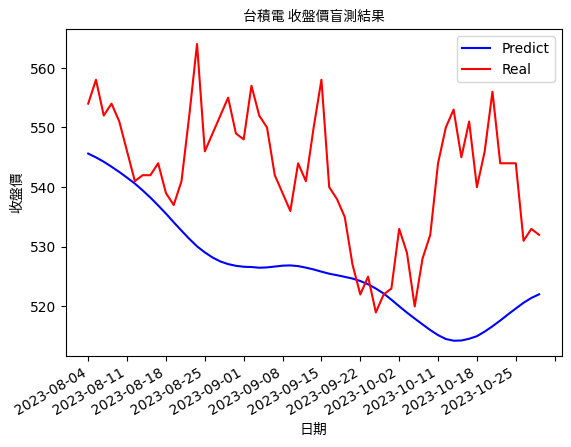

In [30]:
# Get the Predict Price (with date)
Y_pred = model.predict(test_set)
Y_pred_price = scaler.inverse_transform(Y_pred)
Y_pred_price = pd.DataFrame(data=Y_pred_price)
Y_pred_price.columns = ["收盤價"]
Y_pred_price.index = dataset.index[-len(Y_pred_price):].strftime("%Y-%m-%d").tolist()

# Get the Real Price (with date)
Y_real_price = dataset.iloc[-len(Y_pred_price):]["Close"].to_frame()
Y_real_price.columns = ["收盤價"]
Y_real_price.index = dataset.index[-len(Y_pred_price):].strftime("%Y-%m-%d").tolist()

# Plot the predict vs. real price
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, 1)

ax.plot(Y_pred_price, color="blue", label="Predict")
ax.plot(Y_real_price, color="red", label="Real")

tick_spacing = 5
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
fig.autofmt_xdate()

plt.title("{} 收盤價盲測結果".format(stockName), fontproperties=myfont)
plt.xlabel("日期", fontproperties=myfont)
plt.ylabel("收盤價", fontproperties=myfont)
plt.legend(loc="best")
plt.show()

# 預測明日股價

In [31]:
# Get Trade Day
import datetime
this_trade_day = dataset.index[-1].to_pydatetime()
next_trade_day = this_trade_day + datetime.timedelta(days=1)
if next_trade_day.isoweekday() in set((6, 7)):
    next_trade_day += datetime.timedelta(days=8-next_trade_day.isoweekday())

# Show Predict Price
lookback_data = [[]]
for i in range(-win_size, 0):
    lookback_data[0].append(X_scale[i].tolist())

lookback_data = np.reshape(lookback_data, (1, win_size, X_scale.shape[1]))
tomorrow_pred = scaler.inverse_transform(model.predict(lookback_data))

print()
print("{}預測收盤價 ----------".format(stockName))
print("最後一日（{}）：{:.2f}".format(this_trade_day.strftime("%Y/%m/%d"), Y_pred_price.iloc[-1][0]))
print("次交易日（{}）：{:.2f}".format(next_trade_day.strftime("%Y/%m/%d"), tomorrow_pred[0][0]))
print("預測漲跌：{:+.2f}".format(tomorrow_pred[0][0] - Y_pred_price.iloc[-1][0]))

# Show Real Price
print()
print("{}真實收盤價 ----------".format(stockName))
print("最後一日（{}）：{:.2f}".format(this_trade_day.strftime("%Y/%m/%d"), dataset.iloc[-1]["Close"]))

if next_trade_day.date() < datetime.date.today():
    next_trade_day_end = next_trade_day + datetime.timedelta(days=1)
    tomorrow_real = yf.download(stockQuery,
                  start=next_trade_day.date().strftime("%Y-%m-%d"),
                  end=next_trade_day_end.date().strftime("%Y-%m-%d"))
    print("次交易日（{}）：{:.2f}".format(next_trade_day.strftime("%Y/%m/%d"), tomorrow_real.iloc[0]["Close"]))
    print("真實漲跌：{:+.2f}".format(tomorrow_real.iloc[0]["Close"] - dataset.iloc[-1]["Close"]))

1/1 [==============================] - 2s 2s/step

台積電預測收盤價 ----------
最後一日（2023/10/30）：522.04
次交易日（2023/10/31）：522.42
預測漲跌：+0.39

台積電真實收盤價 ----------
最後一日（2023/10/30）：532.00
[*********************100%%**********************]  1 of 1 completed
次交易日（2023/10/31）：529.00
真實漲跌：-3.00
